In [131]:

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

#### Import your dataset

Disini coba ganti setiap path sesuai path yang benernya di local kalian / di drive gimana

In [174]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf

#Change every path to your dataset train, and test path

source_path_train = '/Users/arsyaninsa/Documents/Data_Personal/Kuliah/Bangkid/Nyobas Modelling/dataset_dikit/train'
source_path_test = '/Users/arsyaninsa/Documents/Data_Personal/Kuliah/Bangkid/Nyobas Modelling/dataset_dikit/test'


### Prepare Pre-trained model
Download the inception model for pre-trained

In [133]:
import urllib.request

# URL Inception
url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

urllib.request.urlretrieve(url, local_weights_file)


('/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 <http.client.HTTPMessage at 0x149b2fe80>)

### Generate data
Using ImageGenerator from Keras.
This function include augmentation to optimize training data image

In [176]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image, UnidentifiedImageError

def train_val_generators(train_folder, test_folder):
    """
    TRAIN VAL GENERATORS
    """
    # Set the image
    img_size = (150, 150)

    # Instantiate the ImageDataGenerator class
    # augmenting the images
    train_datagen = ImageDataGenerator(
        rescale=1./255.,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255.)

    # Load training images and labels
    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical'
    )

    # Load testing images and labels
    validation_generator = validation_datagen.flow_from_directory(
        test_folder,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical'
    )

    #INI BUAT NGECEK IMAGE YANG GABISA DIBUKA
    # NAnti dia akan ngasi tau nama file image yang ga sesuai format or corrupt data
    for file_path in train_generator.filepaths + validation_generator.filepaths:
        try:
            img = Image.open(file_path)
        except (OSError, Image.UnidentifiedImageError):
            print(f"UnidentifiedImageError: cannot identify image file: {file_path}")

    return train_generator, validation_generator

In [177]:
train_generator, validation_generator = train_val_generators(source_path_train, source_path_test)

Found 11815 images belonging to 15 classes.
Found 1198 images belonging to 15 classes.


In [178]:
# Get a batch of data from the generators
train_images, train_labels = next(train_generator)
validation_images, validation_labels = next(validation_generator)

print(f"Images of training generator have shape: {train_images.shape}")
print(f"Labels of training generator have shape: {train_labels.shape}")
print(f"Images of validation generator have shape: {validation_images.shape}")
print(f"Labels of validation generator have shape: {validation_labels.shape}")

Images of training generator have shape: (32, 150, 150, 3)
Labels of training generator have shape: (32, 15)
Images of validation generator have shape: (32, 150, 150, 3)
Labels of validation generator have shape: (32, 15)


In [179]:
num_validation_samples = len(validation_generator.labels)
print(f"Total number of labels in the validation set: {num_validation_samples}")

Total number of labels in the validation set: 1198


#### Prepare the Inception 3

In [180]:
# grader-required-cell

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [181]:
def create_pre_trained_model(local_weights_file):
  """
  INCEPTION V3
  """
  # Image 150, 150 buat input
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False


  return pre_trained_model

In [182]:
# Pre-trained model summmary

pre_trained_model = create_pre_trained_model(local_weights_file)
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_846 (Conv2D)            (None, 74, 74, 32)   864         ['input_10[0][0]']               
                                                                                                  
 batch_normalization_846 (Batch  (None, 74, 74, 32)  96          ['conv2d_846[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [183]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [185]:
def output_of_last_layer(pre_trained_model):
  """
  Set the last desired output
  """
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [186]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [187]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


###### FINAL MODEL

Cek classnya ada berapa

In [188]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

def create_final_model(pre_trained_model, last_output):
  """
  FINAL MODEL
  """
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  # Dense Layer
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.5)(x)

  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(0.5)(x)    

  #Softmax 
  # SET YOUR DESIRE CLASS
  x = layers.Dense(15, activation='softmax')(x)           

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Complie optimizer
  model.compile(optimizer = tf.optimizers.Adam(),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

In [189]:

# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 28,378,543 total parameters in this model.
There are 19,403,279 trainable parameters in this model.


In [190]:
#call backs

# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [191]:
# TRAINING FIT
# epoch adjust sesuai kebutuhan
callbacks = myCallback()
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator)

Epoch 1/20
370/370 [==============================] - 105s 280ms/step - loss: 1.8491 - accuracy: 0.4154 - val_loss: 1.1772 - val_accuracy: 0.6260
Epoch 2/20
370/370 [==============================] - 103s 279ms/step - loss: 1.3107 - accuracy: 0.5655 - val_loss: 1.0867 - val_accuracy: 0.6669
Epoch 3/20
370/370 [==============================] - 104s 281ms/step - loss: 1.1803 - accuracy: 0.6178 - val_loss: 0.9795 - val_accuracy: 0.6912
Epoch 4/20
370/370 [==============================] - 103s 279ms/step - loss: 1.1116 - accuracy: 0.6356 - val_loss: 0.9348 - val_accuracy: 0.7304
Epoch 5/20
370/370 [==============================] - 103s 277ms/step - loss: 1.0769 - accuracy: 0.6543 - val_loss: 0.8468 - val_accuracy: 0.7396
Epoch 6/20
370/370 [==============================] - 104s 280ms/step - loss: 1.0084 - accuracy: 0.6734 - val_loss: 0.8296 - val_accuracy: 0.7295
Epoch 7/20
370/370 [==============================] - 103s 279ms/step - loss: 1.0071 - accuracy: 0.6814 - val_loss: 0.7989 -

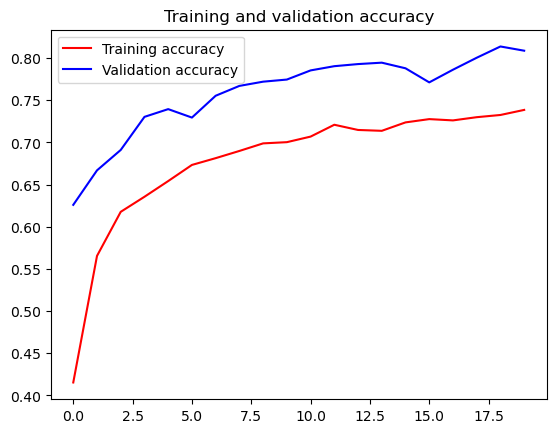

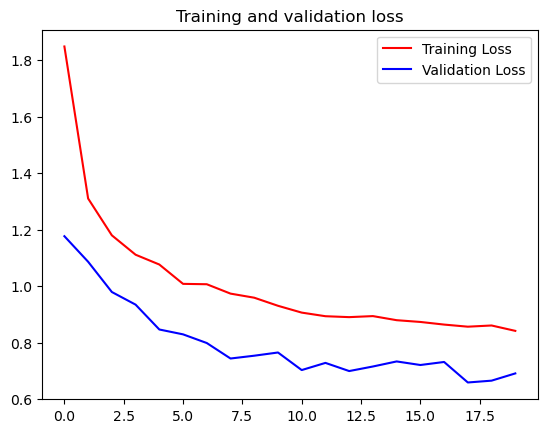

In [198]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()


In [193]:
# Get the class labels and their corresponding indices
class_labels = train_generator.class_indices

# Reverse the dictionary to get the label-to-index mapping
label_to_index = {v: k for k, v in class_labels.items()}

class_names = []

# Print the labels
print("Class Labels:")
for label, index in label_to_index.items():
    print(f"Index: {index}, Label: {label}")
    class_names.append(index)

Class Labels:
Index: Aglaonema, Label: 0
Index: Apple, Label: 1
Index: Aster, Label: 2
Index: Daisy, Label: 3
Index: Grape, Label: 4
Index: Iris, Label: 5
Index: Jasmine, Label: 6
Index: Lavender, Label: 7
Index: Marigold, Label: 8
Index: Orchid, Label: 9
Index: Poppy, Label: 10
Index: Potato, Label: 11
Index: Rose, Label: 12
Index: Soybean, Label: 13
Index: sunflower, Label: 14


In [196]:

# Load the image you want to predict
image_path = "/Users/arsyaninsa/Documents/Data_Personal/Kuliah/Bangkid/Nyobas Modelling/dataset_many/rose.jpeg"
image = Image.open(image_path)
image = image.resize((150, 150))  # Resize the image to match the input size of the model

# Preprocess the image
image_array = np.array(image) / 255.0
image_array = np.expand_dims(image_array, axis=0)  # Add a batch dimension

# Make the prediction
prediction = model.predict(image_array)
predicted_class_index = np.argmax(prediction)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 73ms/step
Predicted class: Rose


In [197]:
model.save("/Users/arsyaninsa/Documents/Data_Personal/Kuliah/Bangkid/Nyobas Modelling/model/InceptionV3_150_(Dataset_Dikit).h5")